# STEP 48 다중 클래스 분류
- 이전 단계에서 소프트맥스 함수와 교차 엔트로피 오차를 구했다. 
- 이번 단계에서는 '스파이럴 데이터셋'이라는 작은 데이터 셋을 사용하여 다중 클래스 분류를 실제로 한다.  

  (스파이럴은 나선형 혹은 소용돌이 모양을 뜻)

## 48.1 스파이럴 데이터셋
- DeZero의 dezero/datasets.py 모듈에는 데이터 셋 관련 클래스와 함수가 준비되어 있다. 
- 머신러닝에서 사용하는 대표적인 데이터 셋 몇 가지 들어있는데, 여기서는 그중 '스파이럴 데이터셋'을 읽어오겠다. 

In [4]:
import dezero

x, t = dezero.datasets.get_spiral(train=True)
print(x.shape)
print(t.shape)

print(x[10], t[10])
print(x[110], t[110])

(300, 2)
(300,)
[-0.12995958 -0.00324155] 1
[ 0.3282343  -0.54941994] 0


- get_spiral 함수는 인수로 train이라는 플래그를 받는다.
- train=True면 학습(훈련)용 데이터를 반환하고, False면 데스트용 데이터를 반환한다. 
- 실제로 반환되는 값은 입력 데이터인 x, 정답 데이터(레이블)인 t
- x와 t는 모두 ndarray 인스턴스이고 형상은 각각 (300, 2)와 (300, )
- 이번-에 다루는 문제는 3클래스 분류이므로 t의 원소는 0, 1, 2중 하나가 된다. 
- 그림 48-1은 x와 t를 그래프로 표현한 모습이다. 


<img src="./images/48-1.png" width="50%" height="50%"></img>  

- 각각의 클래스를 동그라미, 세모, 엑스 기호로 바꿔 그렸다. 
- 데이터가 소용돌이 모양으로 분포한다. 
- 신경망을 사용하여 이 데이터를 정확하게 분류할 수 있는지 살표보자.

## 48.2 학습코드   
- 다중 클래스 분류를 하는 코드이고, 전후반으로 나눠서 보자

In [ ]:
import math
import numpy as np
import dezero
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

# (1)하이퍼파라미터 설정
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

# (2)데이터 읽기 / 모델, 옵티마이져 생성
x, t = dezero.datasets.get_spiral(train=True)
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

- 지금까지 본 코드와 거의 같다. 
- (1)에서 우선 하이퍼파라미터를 설정한다. 하이퍼파라미터는 '사람'이 결정하는 매개변수로 은닉층수, 학습률등이 이에 속한다. 
- (2)에서 데이터셋을 읽고 모델과 옵티마이져 생성
- max_epoch = 300으로 설정했는데, 에포크(epoch)는 일종의 단위로 준비된 데이터 셋을 모두 사용했을 때 1에포크이다. 
- batch_size=30으로 설정하여 데이터를 한번에 30개씩 묶어 처리 하도록 했다. 
- 은닉층 수는 10 이고, 학습률은 1.0이다. 

NOTE_   
데이터가 많을 때는 모든 데이터를 한꺼번에 처리하는 대신 조금씩 무작위로 모아서 처리한다.  
이때의 데이터 뭉치를 미니배치(mini batch)라고 한다.   


In [ ]:
data_size = len(x)
max_iter = math.ceil(data_size / batch_size) # 소수점 반올림

for epoch in range(max_epoch):
    # (3) 데이터셋의 인덱스 뒤섞기 
    index = np.random.permutation(data_size)
    sum_loss = 0

    for i in range(max_iter):
        # (4) 미니배치 생성
        batch_index = index[i * batch_size:(i + 1) * batch_size]
        batch_x = x[batch_index]
        batch_t = t[batch_index]

        # (5) 기울기 산출 / 매개변수 갱신
        y = model(batch_x)
        loss = F.softmax_cross_entropy(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(batch_t)

    # (6)에포크 마다 학습 경과 출력
    avg_loss = sum_loss / data_size
    print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))

- (3)에서는 np.random.permutation 함수를 사용하여 데이터셋의 인덱스를 무작위로 섞는다.
- 이 함수는 인수로 N을 주면 0에서 N-1까지의 정수가 무작위로 배열된 리스트를 반환한다. 
- 에포크별로 무작위로 정렬된 색인 리스트를 새로 생성하였다.

- (4)에서는 미니배치를 생성한다. 
- batch_index는 방금 생성한 index에서 앞에서부터 차례로 꺼내 사용한다. 
- batch_x 와 batch_t 모두 ndarray 인스턴스인데 Variable(batch_x)처럼 명시적으로 Variable로 변환해도 제대로 계산된다. (?)

- (5)에서는 언제나처럼 기울기를 구하고 매개변수를 갱신한다. 

- (6)에서는 에포크마다 손실함수의 결과를 출력한다. 

이상이 스파이럴 데이터셋을 학습하기 위한 코드이다. 

<img src="./images/48-2.png" width="50%" height="50%"></img>   

- 그림 48-2와 같이 학습을 진행할수록 손실이 줄어든다. 올바른 방향으로 학습하고 있다는 뜻.  

- 학습이 완료된 신경망은 클래스 영역, 즉 결정경계(decision boundary)를 어떻게 구분하고 있는지 아래와 시각화된다.   

<img src="./images/48-3.png" width="50%" height="50%"></img>    

- 그림 48-3과 같이 학습 후 신경망은 '소용돌이' 패턴을 제대로 파악하고 있다. 
- 신경망이 비선형 분리 영역을 학습해낸 것이다.
- 신경망에 은닉층을 추가하면 복잡한 표현도 가능해진다.
- 층을 더 깊게 쌓는 식으로 표현력을 키울 수 있다는 것이 딥러닝의 특징이다.

In [ ]:
# step 48 코드
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
import math
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import optimizers
import dezero.functions as F
from dezero.models import MLP

# Hyperparameters
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

x, t = dezero.datasets.get_spiral(train=True)
model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(x)
max_iter = math.ceil(data_size / batch_size)

for epoch in range(max_epoch):
    # Shuffle index for data
    index = np.random.permutation(data_size)
    sum_loss = 0

    for i in range(max_iter):
        batch_index = index[i * batch_size:(i + 1) * batch_size]
        batch_x = x[batch_index]
        batch_t = t[batch_index]

        y = model(batch_x)
        loss = F.softmax_cross_entropy(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(batch_t)

    # Print loss every epoch
    avg_loss = sum_loss / data_size
    print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))
#--------------------------------------------------------------------------------
# Plot boundary area the model predict
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]

with dezero.no_grad():
    score = model(X)
predict_cls = np.argmax(score.data, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)

# Plot data points of the dataset
N, CLS_NUM = 100, 3
markers = ['o', 'x', '^']
colors = ['orange', 'blue', 'green']
for i in range(len(x)):
    c = t[i]
    plt.scatter(x[i][0], x[i][1], s=40,  marker=markers[c], c=colors[c])
plt.show()

# STEP 49 Dataset 클래스와 전처리

- 스파이럴 데이터셋은 300개 정도의 작은 데이터셋이라서 ndarray 인스턴스 하나로 처리할수 있었지만, 대규모 데이터셋을 처리할 때는 문제가 된다. 
- 거대한 데이터를 하나의 ndarray 인스턴스로 처리하면 모든 원소를 한꺼번에 메모리에 올려하는 문제가 있다.
- 그 문제에 대응할 수 있도록 데이터셋 전용 클래스인 Dataset 클래스를 만든다. 
- Dataset클래스에는 데이터를 전처리할 수 있는 구조도 추가할 것이다. 

## 49-1 Dataset 클래스 구현  
- Dataset 클래스는 기반 클래스로서의 역할을 하고, 
- 사용자가 실제로 사용하는 데이터셋은 이를 상속하여 구현하게 할것이다. 
- Dataset 클래스를 구현해보자. 

In [6]:
import numpy as np

class Dataset:
    def __init__(self, train=True):
        self.train = train
        self.data = None
        self.label = None
        self.prepare()
    
    def __getitem__(self, index):
        assert np.isscalar(indx) #index는 정수(스칼라)만 지원
        if self.label is None:
            return self.data[index], None
        else:
            return self.data[index], self.label[index]
        
    def __len__(self):
        return len(self.data)
    
    def prepare(self):
        pass

- 우선 초기화 때 train 인수를 받는다. 이 인수는 '학습'과 '테스트'를 구별하기위한 플래그이다. 
- 인스턴스 변수 data와 label에는 각각 입력데이터와 레이블 보관한다.
- 자식클래스에서는 prepare 메서드가 데이터 준비작업을 하도록 구현해야 한다.
- 중요한 메서드는 `__getitem__` 과 `__len__` 메서드이다. 두 메서드가 있어야 'DeZero 데이터셋'이라고 할 수 있다. 
- 이렇게 인터페이스를 통일하면 다양한 데이터셋을 교체해가며 사용할 수가 있다. 
- `__getitem__` 특수메서드로 괄호를 사용해 접근할 때의 동작을 정의하고, 메서드는 단순히 지정된 인덱스에 위치하는 데이터를 꺼낸다.  
- 레이블 데이터가 없다면 입력 데이터 self.data[index]의 레이블은 None을 반환한다.
- 데이터셋의 길이를 알려주는 `_len_`메서드는 len 함수를 사용할 때 호출된다.   

`CAUTION_ `   
`_getitem_`메서드는 '슬라이스'조작도 처리할 수 있다. 그러나 DeZero의 Dataset 클래스는 슬라이스에는 대응하지 않고, 단순히 정수를 index로 사용하는 조작법만 지원하게 했다. 

In [8]:
class Spiral(Dataset):
    def prepare(self):
        self.data, self.label = get_spiral(self.train)

- Dataset 클래스를 상속하여 스파이럴 데이터셋을 구현한 것이다. 
- prepare 메서드에서는 인스턴스 변수인 data와 label에 데이터를 설정하는게 다이다. 

In [10]:
import dezero

train_set = dezero.datasets.Spiral(train=True)
print(train_set[0])
print(len(train_set))

(array([-0.13981389, -0.00721657], dtype=float32), 1)
300


- Spiral 클래스를 사용하여 데이터를 추출 할 수 있다. 
- 괄호를 사용하여 train_set[0] 형태로 데이터를 가져왔고, 0번째 입력 데이터와 레이블이 튜플로 반환되었다. 

## 49-2 큰 데이터셋의 경우  
- 스파이럴 데이터셋 같은 작은 데이터셋이라면 Dataset 클래스의 인스턴스 변수인 data와 label에 직접 ndarray 인스턴스를 유지해도 무리가 없다.
- 하지만 데이터셋이 훨씬 크면 위와 같은 구현 방식은 사용할 수 없다.   
- 다음과 같이 생각해보았다. 

In [ ]:
class BigData(Dataset):
    def __getitem__(index):
        x = np.load('data/{}.npy'.format(index))
        t = np.load('label/{}.npy'.format(index))
        return x, t
    
    def __len__():
        return 1000000 #백만

- data 디렉토리와 label 디렉토리에 각각 100만 개의 데이터(레이블)가 저장되어 있다고 가정한다. 
- BigData 클래스를 초기화할 때는 데이터를 아직 읽지 않고, 데이터에 접근할 때 비로소 읽게 하는 것이다.
- 구체적으로 `__getitem__(index)` 가 불리는 시점에서 data 디렉토리에 있는 데이터를 읽는다. (np.load 함수는 53단계에서 설명)  
- 'DeZero 데이터셋'이 되기 위한 요건은 `__getitem__`과 `__len__` 두 메서드를 구현하는 것이다.   
- 앞의 BiData 클래스는 요건을 충족하므로 Spiral 클래스처럼 사용할 수 있다. 

## 49-3 데이터 이어 붙이기 
- 이어서 Spiral 클래스를 사용하여 학습코드를 작성해보자. 
- 신경망를 학습시킬 때는 데이터셋 중 일부를 미니배치로 꺼낸다. 
- 다음음 Spiral 클래스를 사용하여 데이터를 미니 배치로 가져오는 코드이다. 

In [12]:
train_set = dezero.datasets.Spiral()

batch_index = [0, 1, 2] # 0에서 2번째까지의 데이터를 꺼냄
batch = [train_set[i] for i in batch_index]
# batch = [(data_0, label_0), (data_1, label_1),(data_2, label_2)]

x = np.array([example[0] for example in batch])
t = np.array([example[1] for example in batch])

print(x.shape)
print(t.shape)

(3, 2)
(3,)


- 우선은 인덱스를 지정하여 여러 데이터(미니배치)를 꺼낸다. 
- 이 코드를 실행하면 batch에 여러 데이터가 리스트로 저장된다. 
- 이 데이터를 DeZero의 신경망에 입력하려면 하나의 ndarray 인스턴스로 변환해야 한다. 
- batch의 각 원소에서 데이터(혹은 레이블)만을 꺼내 하나의 ndarray 인스턴스로 변형했다.(이어 붙였다.)
- 드디어 신경망에 입력할 수 있는 형태가 마련되었다. 

## 49-4 학습코드

- Spiral 클래스를 사용하여 학습을 해보겠다. 
- 파이썬 임포트 코드는 생략했고, 달라진 부분은 네군데이다.

In [ ]:
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = dezero.datasets.Spiral(train=True) # 달라진 부분
model = MLP((hidden_size, 10))
optimizer = optimizers.SGD(lr).setup(model)

data_size = len(train_set)
max_iter = math.ceil(data_size / batch_size)

for epoch in range(max_epoch):
    # Shuffle index for data
    index = np.random.permutation(data_size)
    sum_loss = 0

    for i in range(max_iter):
        # Create minibatch
        batch_index = index[i * batch_size:(i + 1) * batch_size]
        batch = [train_set[i] for i in batch_index] # 달라진 부분
        batch_x = np.array([example[0] for example in batch]) # 달라진 부분 
        batch_t = np.array([example[1] for example in batch]) # 달라진 부분 

        y = model(batch_x)
        loss = F.softmax_cross_entropy(y, batch_t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(batch_t)

    # Print loss every epoch
    avg_loss = sum_loss / data_size
    print('epoch %d, loss %.2f' % (epoch + 1, avg_loss))

- 이전 단계에서 달라진 부분은 Spiral 클래스를 사용하는 내용이다. 
- 그에 따라 미니배치를 만드는 부분의 코드를 수정했다.
- 그 외에는 이전단계와 같고, 실행하면 이전 단계와 마찬가지로 손실(loss)이 낮아지는 모습을 확인할 수 있다. 
- Dataset 클래스를 사용하여 신경망을 학습할 수 있게 되었다. 
- Dataset 클래스를 사용하는 이점은 인터페이스를 통일하여 다양한 데이터셋을 똑같은 코드로 처리할 수 있는 것이다. 
- Spiral을 BigData로 교체하는 것만으로 훨씬 큰 데이터셋에 대응할 수 있다. 


## 49-5 데이터 셋 전처리  
- 머신러닝에서는 모델에 데이터를 입력하기 전에 데이터를 특정한 형태로 가공하는 일이 많다. 
- 예를 들어 데이터에서 특정 값을 제거하거나 데이터의 형상을 변형하는 처리이다. 
- 이미지를 회전 혹은 좌우 반전시키거나 데이터 수를 인위적으로 늘리는 기술(데이터 확장)도 자주 사용된다. 
- 전처리(및 데이터 확장)에 대응하기 위해 Dataset 클래스에도 전처리 기능을 추가하겠다. 

In [ ]:
class Dataset:
    def __init__(self, train=True, transform=None, target_transform=None):
        self.train = train
        self.transform = transform # <---
        self.target_transform = target_transform # <---
        if self.transform is None: # <---
            self.transform = lambda x: x # <---
        if self.target_transform is None: # <---
            self.target_transform = lambda x: x # <---

        self.data = None
        self.label = None
        self.prepare()

    def __getitem__(self, index):
        assert np.isscalar(index)
        if self.label is None:
            return self.transform(self.data[index]), None # <---
        else:
            return self.transform(self.data[index]),\  # <---
                   self.target_transform(self.label[index]) # <---

    def __len__(self):
        return len(self.data)

    def prepare(self):
        pass

- 초기화시에 transform 과 target_transform을 새롭게 받는다.   
- 이 인수들은 호출 가능한 객체를 받는다. (예를 들어 '파이썬 함수')
- trainsform은 입력 데이터 하나에 대한 변환을 처리하고, target_transform 레이블 하나에 대한 변환을 처리한다. 
- 이 값이 None이라면 전처리 로직은 lambda x:x로 설정되고, 받은 인수는 그대로 반환한다. 


In [17]:
def f(x):
    y = x / 2.0
    return y

train_set = dezero.datasets.Spiral(transform=f)

- 이 코드는 입력데이터를 1/2로 스케일 변환하는 전처리 예이다.  
- 참고로 Dezero는 데이터 정규화와 이미지 데이터 변환 등 전처리 시 자주 사용되는 변환들을 transforms.py에 뒀다.

In [21]:
from dezero import transforms

f = transforms.Normalize(mean=0.0, std=2.0)
train_set = dezero.datasets.Spiral(transform=f) # 책에 오타 있음

- f 에 의해 입력을 x라 할 때 (x - mean) / std 로 변환이 이루어 진다. 

In [24]:
f = transforms.Compose([transforms.Normalize(mean=0.0, std=2.0),
                       transforms.AsType(np.float64)])

- 변환 처리를 연달아 수행할 수도 있다.
- transform.Compose 클래스는 주어진 변환 목록을 앞에서 순서대로 처리한다. 
- 예에서는 정규화를 먼저 하고, 연이어 데이터 타입을 np.float64로 변환하는 일을 수행한다. 
- transform.py에는 편리한 변환 처리가 준비되어 있다. 참고하라. 

# STEP 50 미니배치를 뽑아주는 DataLoader 
- 이전 단계에서는 Dataset 클래스를 만들어서 통일된 인터페이스로 데이터셋을 다룰 수 있게 했다. 
- 이번 단계에서는 Dataset 클래스에서 미니배치를 뽑아주는 DataLoader 클래스를 구현한다. 
- DataLoader는 미니배치 생성과 데이터 뒤섞기 등의 기능을 제공하여 사용자가 작성해야 할 학습 코드가 더 간단해진다. 
- 반복자가 무엇인지 알아보고, DataLoader 클래스를 구현하는 흐름으로 진행하겠다. 

## 50.1 반복자란
- 이름에서 알 수 있듯이 원소를 반복하여 꺼낸다. 
- 파이썬의 반복자는 리스트나 튜플 등 여러 원소를 담고 있는 데이터 타입으로부터 데이터를 순차적으로 추출하는 기능을 제공한다. 

In [25]:
t = [1, 2, 3]
x = iter(t)
next(x)

1

In [26]:
next(x)

2

In [27]:
next(x)

3

In [29]:
next(x)

StopIteration: 

- 리스트를 반복자로 변환하려면 iter함수를 사용한다. 이 코드는 리스트 t에서 x라는 반복자를 만들었다. 
- next함수를 사용해 데이터를 순서대로 추출한다. 
- 네번째 실행에서는 원소가 더 이상 존재하지 않기 때문에 StopIteration 예외가 발생했다. 

NOTE_  
for 문에서 리스트의 원소를 꺼낼 때 내부적으로 반복자가 이용된다.   
예를 들어 t = [1, 2, 3]일 때 for x in t: x를 실행하면 리스트 t가 내부적으로 반복자로  변환된다. 

In [30]:
class MyIterator:
    def __init__(self, max_cnt):
        self.max_cnt = max_cnt
        self.cnt = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.cnt == self.max_cnt:
            raise StopIteration()
        
        self.cnt += 1
        return self.cnt

- 위 코드는 고유한 반복자를 만들어 준다. 
- MyIterator라는 클래스를 구현했다.
- 클래스를 파이썬 반복자로 사용하려면 `__iter__`특수 메서드를 구현하고 자기 자신(self)을 반환하도록 한다. 
- `__next__` 특수 메서드에서는 다음 원소를 반환하도록 구현한다. 
- 만약 반환할 원소가 없다면 raise StopIteration()을 수행한다. 


In [31]:
obj = MyIterator(5)
for x in obj:
    print(x)

1
2
3
4
5


- for x in obj: 구문을 사용하여 원소를 꺼낼 수 있다. 
- 다음은 반복자 구조를 이용하여 미니배치를 뽑아주는 DataLoader 클래스를 구현한다. 
- 기본적으로 DataLoader는 주어진 데이터셋의 첫 데이터부터 차례로 꺼내주지만, 필요에 따라 뒤섞을 수 있다. 

In [23]:
import math
import random
import numpy as np

class DataLoader:
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_size = len(dataset)
        self.max_iter = math.ceil(self.data_size / batch_size)

        self.reset()

    def reset(self):
        self.iteration = 0 # 반복 횟수 초기화
        if self.shuffle:
            self.index = np.random.permutation(len(self.dataset)) # 데이터 뒤섞기
        else:
            self.index = np.arange(len(self.dataset))

    def __iter__(self):
        return self

    def __next__(self):
        if self.iteration >= self.max_iter:
            self.reset()
            raise StopIteration

        i, batch_size = self.iteration, self.batch_size
        batch_index = self.index[i * batch_size:(i + 1) * batch_size]
        batch = [self.dataset[i] for i in batch_index]
        x = xp.array([example[0] for example in batch])
        t = xp.array([example[1] for example in batch])

        self.iteration += 1
        return x, t

    def next(self):
        return self.__next__()

- 초기화 메서드는 다음 인수를 받는다. 
    + dataset: Dataset 인터페이스를 만족하는 인스턴스
    + batch_size : 배치 크기
    + shuffle : 에포크별 데이터셋을 뒤섞을지 여부 
- 초기화 코드는 인수를 인스턴스 변수로 저장한 후 reset 메서드를 부른다. 
- reset메서드에서는 인스턴스 변수의 반복 횟수를 0으로 설정하고 필요에 따라 데이터이 인덱스를 뒤섞는다. 
- `__next__` 메서드는 미니배치를 꺼내 ndarray 인스턴스로 변환한다. 
- `dezero/__init__.py` 에 from dezero.dataloaders import DataLoader라는 임포트문을 추가하면 사용자는 DataLoader를 임포트할 수 있다. 

CAUTION_   
dezero/dataloaders.py의 DataLoader클래스는 데이터를 GPU로 전송하는 로직도 포함하지만 지면에서 생략한다. 
GPU는 52단계에서 진행

## 50.2 DataLoader 사용하기  
- DataLoader 클래스를 사용하면 미니배치를 꺼내오는 일이 간단해진다. 
- 시험삼아 신경망 학습을 가정하고 DataLoader를 사용해보겠다. 

In [22]:
from dezero.datasets import Spiral
from dezero import DataLoader

batch_size = 10
max_epoch = 1

train_set = Spiral(train=True)
test_set = Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

for epoch in range(max_epoch):
    for x, t in train_loader:
        print(x.shape, t.shape) # x, t는 훈련데이터
        break
        
    # 에포크 끝에서 테스트 데이터를 꺼낸다.     
    for x, t in test_loader:
        print(x.shape, t.shape) # x, t는 테스트 데이터
        break

(10, 2) (10,)
(10, 2) (10,)


- 훈련용과 테스트용 각각, 총 두개의 DataLoader를 생성했다. 
- 훈련용 DataLoader는 에포크별로 데이터를 뒤섞어야 하기 때문에 shuffle=True(기본값) 으로 설정한다. 
- 테스트용 DataLoader는 정확도 평가에만 사용하므로 shuffle=False로 설정한다. 
- 이렇게 해주면 이후 미니배치 추출과 데이터 뒤섞기는 DataLoader가 알아서 해준다. 


## 50.3 accuracy 함수 구현하기
- DataLoader를 사용해보기 전에 편의 기능을 하나 추가하자. 

In [36]:
def accuracy(y, t):
    y, t = as_variable(y), as_variable(t)
    
    pred = y.data.argmax(axis=1).reshape(t.shape)
    result = (pred == t.data)
    acc = result.mean()
    return Variable(as_array(acc))

- accuracy 함수는 인수 y와 t를 받아서 '정답률'을 계산해준다. 
- y는 신경망의 예측 결과이고, t는 정답 데이터이다. 이 두 인수는 Variable 또는 ndarray 인스턴스여야 한다. 
- 내용을 보면 먼저 신경망의 예측 결과를 구해 pred에 저장한다. 예측 결과의 최대 인덱스를 찾아서 형상을 변경해야 한다. 
- pred와 정답 데이터 t를 비교하면 결과는 True / False의 텐서(ndarray)가 된다. 
- 이 텐서의 True 비율(평균)이 정답률에 해당한다. 
- 코드 마지막줄에 as_array 함수를 사용하고 있다. 
- result.mean()이 반환하는 데이터의 형식이 np.float64나 np.float32이기 때문에 as_array함수를 이용하여 ndarray 인스턴스로 변환한 것이다. 

CAUTION_  
accuracy 함수는 Variable 인스턴스를 반환합니다만 내부 계산은 ndarray 인스턴스를 사용해 수행한다. 
따라서 accuracy 함수로 수행한 계산은 미분할 수 없다. 


In [21]:
import numpy as np
import dezero.functions as F

y = np.array([[0.2, 0.8, 0], [0.1, 0.9, 0], [0.8, 0.1, 0.1]])
t = np.array([1, 2, 0])
acc = F.accuracy(y, t)
print(acc)

variable(0.6666666666666666)


- y에 담긴 3개의 샘플 데이터에 대한 신경망이 어떻게 예측하는지 보았다. (3-클래스 분류)
- 정답 데이터인 t에는 각 샘플 데이터의 정답 인덱스가 부여되어 있다. 
- 결과는 0.6666... 정확하게 나왔다.(0번과 2번 샘플은 정답을 맞혔고, 1번 샘플에 대해서는 틀렸으니 정확도는 2/3)

## 50.4 스파이럴 데이터셋 학습코드  
DataLoader 클래스와 accuracy 함수를 사용하여 스파이럴 데이터셋을 학습해보자. 

In [ ]:
max_epoch = 300
batch_size = 30
hidden_size = 10
lr = 1.0

train_set = dezero.datasets.Spiral(train=True)
test_set = dezero.datasets.Spiral(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, 3))
optimizer = optimizers.SGD(lr).setup(model)

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader: # (1) 훈련용 미니배치 데이터 
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t) # (2) 훈련 데이터의 인식 정확도 
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(train_set), sum_acc / len(train_set)))

    sum_loss, sum_acc = 0, 0
    with dezero.no_grad(): # (3)기울기 불필요 모드
        for x, t in test_loader: # (4)테스트용 미니배치 데이터
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t) # (5)테스트 데이터의 인식 정확동 
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)

    print('test loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(test_set), sum_acc / len(test_set)))

- (1)에서는 DataLoader를 사용해 미니배치를 꺼내고, 
- (2)에서 accuracy 함수를 사용하여 인식 정확도를 계산한다.
- (3)에서는 에포크별로 테스트 데이터셋을 사용하여 훈련결과를 평가한다
- 테스트 시에는 역전파가 필요 없으므로 with dezero.no_grad(): 블록 내부로 들어간다. 이렇게 함으로써 역전파 관련 처리와 자원소모를 피할 수 있다.
- (4)에서는 테스트용 DataLoader에서 미니배치 데이터를 꺼내 평가한다. 
- (5)에서는 마지막으로 accuracy 함수를 사용하여 인식 정확도를 계산한다.  

<img src="./images/50-1.png" ></img>  

- 그림50-1을 보면 에포크가 진행됨에 따라 손실(loss)이 낮아지고 인식 정확도(accuracy)는 상승하고 있다. 
- 학습이 제대로 이루어지고 있다는 증거이다.
- 또한, 훈련(train)과 테스트(test)의 차이가 작은데, 모델이 과대적합을 일으키지 않았다는 뜻이다. 

NOTE_  
과대적합(overfiting)은 특정 훈련 데이터에 지나치게 최적화된 상태를 말한다.    
새로운 데이터에서는 예측 정확도가 훨씬 떨어지는, 일반화되지 못한 상태를 뜻한다.   
신경망으로는 표현력이 높은 모델을 만들 수 있기 때문에 과대적합이 흔하게 일어난다.  

# STEP 51 MNIST 학습  

- 지금까지 데이터셋을 쉽게 다룰 수 있는 구조를 마련했다. 
- Dataset 클래스로 데이터셋 처리를 위한 공통 인터페이스를 마련했고,
- '전처리'를 설정할 수 있도록 했다. 
- DataLoader 클래스로는 Dataset에서 미니배치 단위로 데이터를 꺼내올 수 있게 했다.   
<img src="./images/51-1.png" ></img>  

- 전처리를 수행하는 객체를 호출 가능하다는 뜻에서 Callable로 표시했다. 
- Callable은 Dataset이 보유하고 Dataset은 DataLoader가 보유하는 관계이다. 
- 그리고 사용자는 DataLoader로부터 미니배치를 가져온다. 

## 51.1 MNIST 데이터 셋 
- 우선 MNIST 데이터셋이 무엇인지부터 보자.

In [2]:
import dezero

train_set = dezero.datasets.MNIST(train=True, transform=None)
test_set = dezero.datasets.MNIST(train=True, transform=None)

print(len(train_set))
print(len(test_set))

Downloading: train-images-idx3-ubyte.gz
[##############################] 100.00% Done
Downloading: train-labels-idx1-ubyte.gz
[##############################] 100.00% Done
60000
60000


- 훈련 데이터와 테스트 데이터를 가져옵니다. 
- transform = None으로 설정하여 아무런 전처리도 수행하지 않도록 했다. 
- 훈련 데이터(train_set)와 테스트 데이터(test_set)의 길이를 확인해보니 각각 60000과 10000이 나왔다. 


In [3]:
x, t = train_set[0]
print(type(x), x.shape)
print(t)

<class 'numpy.ndarray'> (1, 28, 28)
5


- train_set 의 0번째 샘플 데이터를 확인해보는 코드이다. 
- MNIST 데이터셋도 (data, label) 튜플 형태로 구성되어 있다. data에는 0~9까지 손글씨 숫자 이미지가 들어있다. 
- data에 1채널(그레이스케일)의 28x28픽셀 이미지 데이터가 들어 있음을 나타낸다. 
- label에는 정답 숫자의 인덱스(0~9)가 들어 있다. 


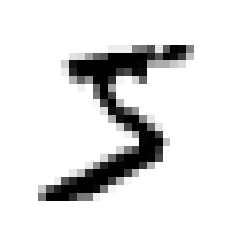

label: 5


In [12]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# 데이터 예시

x, t = train_set[0] # 0번째 (data, label) 추출
plt.imshow(x.reshape(28,28), cmap=mpl.cm.binary) #넘파이 타입 데이터를  이미지로 출력
plt.axis("off")
plt.show()
print('label:', t)

<img src="./images/51-2.png" width="50%" height="50%"></img>  

- 이 손글씨 이미지 데이터를 지금부터 신경망으로 학습할 것이다. 
- 입력데이터를 전처리하자. 

In [ ]:
def f(x):
    x = x.flatten()
    x = x.astype(np.float32)
    x /= 255.0
    return x

train_set = dezero.datasets.MNIST(train=True, transform=f)
test_set = dezero.datasets.MNIST(train=False, transform=f)

- (1,28,28) 형상인 입력 데이터를 1열로 나열(평탄화flatten)하여 (784,)형상으로 변환한다. 
- 데이터 타입은 np.float32(32비트 부동소수점)로 변환한다. 
- 마지막으로 255.0으로 나눠서 값의 범위가 0.0 ~ 1.0 사이가 되도록 한다. 
- MNIST 클래스에서는 방금 설명한 전처리가 기본으로 설정되어 있다. 
- dezero.datasets.MNIST(train=True)로 호출하면 이상의 전처리가 자동으로 수행된다. 

## 51.2 MNIST 데이터 학습하기
- 학습해보자.

In [24]:
from dezero import DataLoader

max_epoch = 5
batch_size = 100
hidden_size = 1000

train_set #= dezero.datasets.MNIST(train=True)
test_set #= dezero.datasets.MNIST(train=False)
train_loader = DataLoader(train_set, batch_size)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

model = MLP((hidden_size, 10))
optimizer = optimizers.SGD().setup(model)
#model = MLP((hidden_size, hidden_size, 10), activation=F.relu)
#optimizer = optimizers.Adam().setup(model)

for epoch in range(max_epoch):
    sum_loss, sum_acc = 0, 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        acc = F.accuracy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()

        sum_loss += float(loss.data) * len(t)
        sum_acc += float(acc.data) * len(t)

    print('epoch: {}'.format(epoch+1))
    print('train loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(train_set), sum_acc / len(train_set)))

    sum_loss, sum_acc = 0, 0
    with dezero.no_grad():
        for x, t in test_loader:
            y = model(x)
            loss = F.softmax_cross_entropy(y, t)
            acc = F.accuracy(y, t)
            sum_loss += float(loss.data) * len(t)
            sum_acc += float(acc.data) * len(t)

    print('test loss: {:.4f}, accuracy: {:.4f}'.format(
        sum_loss / len(test_set), sum_acc / len(test_set)))

epoch: 1
train loss: 1.9304, accuracy: 0.2800
test loss: 1.3898, accuracy: 0.4367
epoch: 2
train loss: 1.3086, accuracy: 0.4367
test loss: 1.2032, accuracy: 0.5100
epoch: 3
train loss: 1.1784, accuracy: 0.4767
test loss: 1.1303, accuracy: 0.5033
epoch: 4
train loss: 1.1146, accuracy: 0.5333
test loss: 1.0888, accuracy: 0.5867
epoch: 5
train loss: 1.0726, accuracy: 0.6300
test loss: 1.0534, accuracy: 0.5433


- 이번 단계에서 달라진 점은 MNIST 데이터셋을 사용한다는 것과 하이퍼파라미터값을 변경한 정도이다. 
- 인식 정확도는 테스트 데이터셋에서 약 86%를 얻었다. 
- 에포크 수를 늘리면 정확도가 올라가겠지만, 개선할 점이 눈에 띄어 마지막 정확한 모델로 개선해보자.

## 51.3 모델 개선
- 방금 이용한 신경망의 활성화 함수는 시그모이드 함수였다. 
- 그런데 최근에는 ReLU (rectified linear unit)라는 함수가 더 자주 사용된다. 
- ReLU는 입력이 0보다 크면 입력 그대로 출력하고, 0 이하면 0을 출력하는 함수이다. 
$$h(x)=\begin{cases}
x \text{ }(x>0) \\
0 \text{ }(x\leq0)
\end{cases}$$
- 아래와 같이 쉽게 구현했다. 

In [ ]:
class ReLU(Function):
    def forward(self, x):
        xp = cuda.get_array_module(x)
        y = xp.maximum(x, 0.0) # (1)
        return y

    def backward(self, gy):
        x, = self.inputs
        mask = x.data > 0 #(2)
        gx = gy * mask #(3)
        return gx


def relu(x):
    return ReLU()(x)

- (1) 순전파에서는 np.maximum(x, 0, 0)에 의해 x의 원소와 0.0중 큰 쪽을 반환한다. 
- 역전파에서는 입력 x에서 0보다 큰 원소에 해당하는 위치의 기울기는 그대로 흘려보내고,
- 0 이하라면 기울기를 0으로 설정해야한다. 
- 따라서 출력쪽에서 전해지는 기울기를 '통과시킬지'표시한 마스크(mask)를 준비한 후 (2), 기울기를 곱한다.(3)

In [ ]:
#model = MLP((hidden_size, 10))
model = MLP((hidden_size, hidden_size, 10), activation=F.relu)

- ReLU 함수를 사용하여 새로운 3층 신경망을 만들었다. 
- 앞 절보다 층수를 늘려 표현력을 높인 것이다. 
- 활성화 함수를 ReLU로 바꿔서 학습이 더 효율적으로 이루어질 것이다. 
- 신경망을 사용하여 최적화 기법을 SGD에서 Adam으로 바꾼 후 학습을 수행하면 훈련욜 데이터로는 99%, 테스트용 데이터로는 약 98%라는 인식 정확도를 얻을 것이다. 

******
- 이것으로 4고지 정복했다. 
- 드디어 DeZero를 딥러닝 프레임워크라고  부를 수 있게 되었다. 
- 지금까지 배운지식은 파이토치와 체이너 같은 유명 프레임워크와 통한다. 
- 우리는 '살아있는 지식'을 손에 넣었다. 

### 칼럼 : 딥러닝 프레임워크

- Define-by-Run 방식의 자동미분
- 계층 컬렉션
- 옵티마이져 컬렉션


`[DeZero 프레임워크 핵심 클래스 구조]`    

<img src="https://raw.githubusercontent.com/WegraLee/deep-learning-from-scratch-3/master/DeZeroClasses.png"></img>